In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Device Setup

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
train_dir = '/content/drive/MyDrive/plant_village_updated/plant_village_updated/train'
test_dir = '/content/drive/MyDrive/plant_village_updated/plant_village_updated/test'
val_dir = '/content/drive/MyDrive/plant_village_updated/plant_village_updated/val'

Transforming the data

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Loading dataset

In [6]:
train_dataset = datasets.ImageFolder(train_dir,transform=transform)
val_dataset = datasets.ImageFolder(val_dir,transform=transform)
test_dataset = datasets.ImageFolder(test_dir,transform=transform)


Hyperparameters

In [8]:
batch_size = 32
lr=1e-4

Making Dataloader

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
for train_images,_ in train_dataloader:
    print(train_images.shape)
    print(_)
    break

torch.Size([32, 3, 224, 224])
tensor([18, 19, 13, 10,  9, 25,  7,  5,  8,  0, 24, 12, 23,  1, 26, 24, 26,  2,
        13, 25,  5, 25, 16,  2,  1, 12,  9, 25, 21, 16, 14, 12])


Model Initialization

In [11]:
model = models.resnet50(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features,num_classes) #to make the model to have the same no of class as i want

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Training Pipeline

In [12]:
n_epoch = 10
criterion = nn.CrossEntropyLoss()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [14]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded: epoch {checkpoint['epoch']}")
    return start_epoch

# Try to load checkpoint if exists (set your checkpoint path)
start_epoch = 1
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
if os.path.isfile(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer)

In [15]:
def train_one_step(model, criterion, optimizer, images, labels):
    model.train()
    optimizer.zero_grad()

    outputs = model(images)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return loss.item(), correct

def val_one_step(model, criterion, images, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct = (preds == labels).sum().item()
    return loss.item(), correct

In [16]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths
checkpoint_dir = "/content/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
last_model_path = os.path.join(checkpoint_dir, 'last_model.pth')

# Resume flag
resume_training = True

# Initialize trackers
train_loss, val_loss, train_acc, val_acc = [], [], [], []
best_val_acc = 0
epochs_no_improve = 0
patience = 5
start_epoch = 1

# Resume from checkpoint if available
if resume_training and os.path.exists(last_model_path):
    checkpoint = torch.load(last_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_loss = checkpoint['train_loss_hist']
    val_loss = checkpoint['val_loss_hist']
    train_acc = checkpoint['train_acc_hist']
    val_acc = checkpoint['val_acc_hist']
    best_val_acc = checkpoint['best_val_acc']
    print(f"Resumed training from epoch {start_epoch}")

# Training loop
for epoch in range(start_epoch, n_epoch + 1):
    model.train()
    train_epoch_loss, train_correct, total_train = 0, 0, 0

    for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch}/{n_epoch}'):
        images, labels = images.to(device), labels.to(device)
        loss, correct = train_one_step(model, criterion, optimizer, images, labels)
        batch_size = images.size(0)

        train_epoch_loss += loss * batch_size
        train_correct += correct
        total_train += batch_size

    epoch_train_loss = train_epoch_loss / total_train
    epoch_train_acc = train_correct / total_train

    # Validation
    model.eval()
    val_epoch_loss, val_correct, total_val = 0, 0, 0

    for images, labels in tqdm(val_dataloader, desc=f'Validation Epoch {epoch}/{n_epoch}'):
        images, labels = images.to(device), labels.to(device)
        loss, correct = val_one_step(model, criterion, images, labels)
        batch_size = images.size(0)

        val_epoch_loss += loss * batch_size
        val_correct += correct
        total_val += batch_size

    epoch_val_loss = val_epoch_loss / total_val
    epoch_val_acc = val_correct / total_val

    # Update scheduler
    scheduler.step()

    # Log results
    print(f"Epoch {epoch}/{n_epoch} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Save history
    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    train_acc.append(epoch_train_acc)
    val_acc.append(epoch_val_acc)

    # Save last checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_hist': train_loss,
        'val_loss_hist': val_loss,
        'train_acc_hist': train_acc,
        'val_acc_hist': val_acc,
        'best_val_acc': best_val_acc
    }, last_model_path)

    # Save best checkpoint
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss_hist': train_loss,
            'val_loss_hist': val_loss,
            'train_acc_hist': train_acc,
            'val_acc_hist': val_acc,
            'best_val_acc': best_val_acc
        }, best_model_path)
        print(f"✅ Best model updated at epoch {epoch} with Val Acc: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    # Early stopping
    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered.")
        break



Validation Epoch 1/10: 100%|██████████| 378/378 [29:33<00:00,  4.69s/it]


Epoch 1/10 | Train Loss: 0.1390 | Train Acc: 0.9645 | Val Loss: 0.0388 | Val Acc: 0.9891
✅ Best model updated at epoch 1 with Val Acc: 0.9891


Validation Epoch 2/10: 100%|██████████| 378/378 [01:02<00:00,  6.09it/s]


Epoch 2/10 | Train Loss: 0.0377 | Train Acc: 0.9888 | Val Loss: 0.0291 | Val Acc: 0.9906
✅ Best model updated at epoch 2 with Val Acc: 0.9906


Validation Epoch 3/10: 100%|██████████| 378/378 [01:05<00:00,  5.73it/s]


Epoch 3/10 | Train Loss: 0.0291 | Train Acc: 0.9915 | Val Loss: 0.0187 | Val Acc: 0.9948
✅ Best model updated at epoch 3 with Val Acc: 0.9948


Validation Epoch 4/10: 100%|██████████| 378/378 [01:03<00:00,  5.95it/s]


Epoch 4/10 | Train Loss: 0.0246 | Train Acc: 0.9926 | Val Loss: 0.0172 | Val Acc: 0.9946
No improvement for 1 epochs.


Validation Epoch 5/10: 100%|██████████| 378/378 [01:04<00:00,  5.84it/s]


Epoch 5/10 | Train Loss: 0.0197 | Train Acc: 0.9939 | Val Loss: 0.0220 | Val Acc: 0.9930
No improvement for 2 epochs.


Validation Epoch 6/10: 100%|██████████| 378/378 [01:05<00:00,  5.77it/s]


Epoch 6/10 | Train Loss: 0.0165 | Train Acc: 0.9945 | Val Loss: 0.0131 | Val Acc: 0.9949
✅ Best model updated at epoch 6 with Val Acc: 0.9949


Validation Epoch 7/10: 100%|██████████| 378/378 [01:03<00:00,  5.91it/s]


Epoch 7/10 | Train Loss: 0.0161 | Train Acc: 0.9952 | Val Loss: 0.0213 | Val Acc: 0.9949
No improvement for 1 epochs.


Validation Epoch 8/10: 100%|██████████| 378/378 [01:01<00:00,  6.12it/s]


Epoch 8/10 | Train Loss: 0.0042 | Train Acc: 0.9990 | Val Loss: 0.0043 | Val Acc: 0.9988
✅ Best model updated at epoch 8 with Val Acc: 0.9988


Validation Epoch 9/10: 100%|██████████| 378/378 [01:00<00:00,  6.22it/s]


Epoch 9/10 | Train Loss: 0.0018 | Train Acc: 0.9996 | Val Loss: 0.0040 | Val Acc: 0.9988
No improvement for 1 epochs.


Validation Epoch 10/10: 100%|██████████| 378/378 [01:01<00:00,  6.19it/s]


Epoch 10/10 | Train Loss: 0.0011 | Train Acc: 0.9998 | Val Loss: 0.0048 | Val Acc: 0.9988
No improvement for 2 epochs.


## Training Curve

> Add blockquote



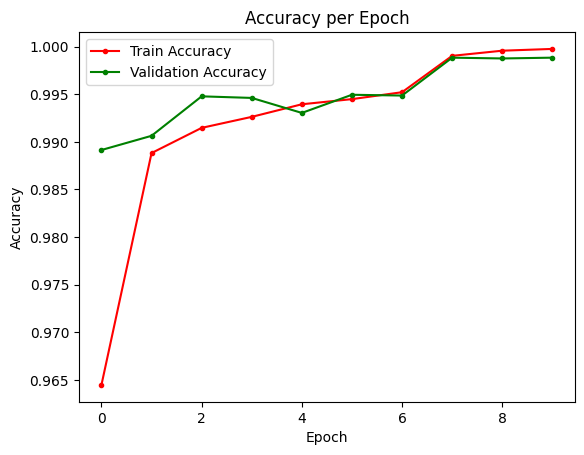

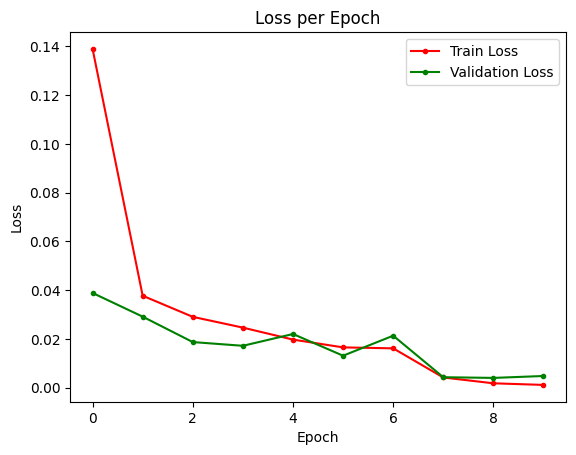

In [17]:
# After training, plot metrics
plt.figure()
plt.plot(train_acc, 'r.-', label='Train Accuracy')
plt.plot(val_acc, 'g.-', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_loss, 'r.-', label='Train Loss')
plt.plot(val_loss, 'g.-', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()


## Evaluation


In [18]:
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model, test_dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0

    for test_images, test_labels in tqdm(test_dataloader, desc="Evaluating"):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        outputs = model(test_images)  # shape: (batch_size, num_classes)
        _, preds = torch.max(outputs, 1)  # predicted class indices
        total_correct += (preds == test_labels).sum().item()
        total_samples += test_labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy

print("Accuracy of model on test dataset: ", evaluate(model, test_dataloader))


Evaluating: 100%|██████████| 43/43 [03:22<00:00,  4.70s/it]

Accuracy of model on test dataset:  0.9992614475627769
